In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from hrv_extraction.Stress.Physiological import HRV, stress_baevskiy
from support_functions import peak_analysis,  peak_detection_gt
from hrv_algs import Signal_Postprocessing

In [3]:
# import dataset. In this case Stroop dataset

PATH = "D:\\dataset\\StressData\\final_setup3"
STROOP_PATH = "C:\\Users\\HKIS Admin\\Desktop\\vital_signs\\StressExperiment\\data"
files = os.listdir(PATH)

In [4]:
SDNN_data = np.zeros((14, 3))
RMSSD_data = SDNN_data.copy()
baevskiy_data = SDNN_data.copy()
LFHF_data = SDNN_data.copy()
NS = np.zeros(14)
TS1 = NS.copy()
TS2 = NS.copy()
sdnn_data_vid = SDNN_data.copy()
rmssd_data_vid = SDNN_data.copy()
baevskiy_data_vid = SDNN_data.copy()
lfhf_data_vid = SDNN_data.copy()

In [5]:
win = 14.5 # sec
band = 0.25 # Hz
stepp = 2.82 # sec

In [8]:

for i in range(len(files)):
    
    ff = np.load(PATH + '/' + files[i] + '/' +
                 files[i] + '.npz', allow_pickle=True)
    dictionary = ff['arr_0'].item()
    keyss = dictionary.keys()
    keys = []
    
    for key in keyss:
        keys.append(key)
    
    for j in range(3):    
        
        ############ GT  ###########
        PPG = dictionary[keys[j]][:, 1].astype(np.float32)
        timePPG = dictionary[keys[j]][:, 0]
        if (dictionary[keys[j]][:, 2] < 45).any():
            print("there was error in CONTEC ", files[i], key)
        #L = len(PPG)
        #cand_PPG = PPG
        ibi = peak_detection_gt(PPG, 20, 60, 100) # gt pre-process        
        hrv = HRV(ibi)
        sdnn = hrv.sdnn()
        rmssd = hrv.rmssd()
        lfhf = hrv.freq_domain(window=16)['LF/HF']
        baevskiy = stress_baevskiy(ibi)
        
        if sdnn > 100 or rmssd > 100:
            continue
    
        SDNN_data[i, j] = sdnn
        RMSSD_data[i, j] = rmssd
        baevskiy_data[i, j] = baevskiy
        LFHF_data[i, j] = lfhf
    
    
        ######################  rPPG    ############
    
        meanRGB = dictionary[keys[j+5]][:, :3].astype(np.float32)
        time_data = dictionary[keys[j+5]][:, 3]
        info_time = np.zeros(meanRGB.shape[0])
    
        for m in range(1, len(info_time)):
            info_time[m] = (
                time_data[m] - time_data[0]).total_seconds()
        rPPG_cand = POS(meanRGB, 60, 10)

        fs = 64
        
        ### algorithm to obtain refined IBIs and cleaned_rPPG   ###
        post_process = Signal_Postprocessing(rPPG_cand, fs, interpolate = True, time_data = info_time, interp_freq = 64)
        cleaned_rPPG, ibi_ = post_process.HRV1_2(window_size = win, band = band, step = stepp)  # HRV1.2
        ##cleaned_rPPG, ibi_ = post_process.HRV1_0(window_size = win, band = band, step = stepp)  # HRV1.0
        
        
        #### calculate HRV from refined IBIs ####
        hrv_ = HRV(ibi_)
        sdnn_ = hrv_.sdnn()
        rmssd_ = hrv_.rmssd()
        baevskiy_ = stress_baevskiy(ibi_)
        lfhf_ = hrv_.freq_domain(window=16)['LF/HF']
    
        sdnn_data_vid[i, j] = sdnn_
        rmssd_data_vid[i, j] = rmssd_
        baevskiy_data_vid[i, j] = baevskiy_
        lfhf_data_vid[i, j] = lfhf_
  
        

 
AE_SDNN = abs(SDNN_data - sdnn_data_vid).reshape(-1,)
AE_RMSSD = abs(RMSSD_data - rmssd_data_vid).reshape(-1,)
AE_baevsky = abs(baevskiy_data - baevskiy_data_vid).reshape(-1,)
AE_LFHF = abs(LFHF_data - lfhf_data_vid).reshape(-1,)
#k += 1



print(f'step: {stepp}')
print(
    f' SDNN ae: {np.mean(AE_SDNN[AE_baevsky>0], axis = 0)}, sd: {np.std(AE_SDNN[AE_baevsky>0], axis = 0)}')
print(
    f' RMSSD ae: {np.mean(AE_RMSSD[AE_baevsky>0], axis = 0)}, sd: {np.std(AE_RMSSD[AE_baevsky>0], axis = 0)}')
print(
    f' baesky ae: {np.mean(AE_baevsky[AE_baevsky>0], axis = 0)}, sd: {np.std(AE_baevsky[AE_baevsky>0], axis = 0)}')
print(
    f' LF/HF ae: {np.mean(AE_LFHF[AE_baevsky>0], axis = 0)}, sd: {np.std(AE_LFHF[AE_baevsky>0], axis = 0)}')


C:\Users\anaconda3\envs\p3_7\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 13 is greater than input length  = 11, using nperseg = 11
  .format(nperseg, input_length))


step: 2.82
 SDNN ae: 7.132438488141378, sd: 4.9153374711674065
 RMSSD ae: 11.214034876616227, sd: 9.1254808603441
 baesky ae: 39.21351351351352, sd: 46.43202041789325
 LF/HF ae: 0.6794205411016304, sd: 0.731832678199519


Text(0.5, 1.0, 'cleaned_rPPG')

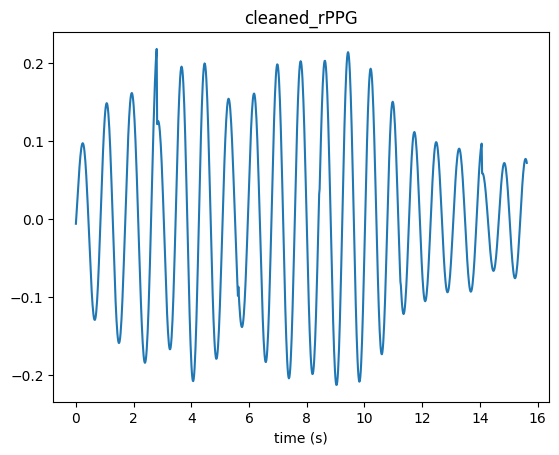

In [10]:
tt = np.linspace(0,1000/64, 1000)
plt.plot(tt,cleaned_rPPG[:1000])
plt.xlabel('time (s)')
plt.title('cleaned_rPPG')